In [ ]:
############## COLLECTING REAL DATA AND CREATING CASE STUDY DATASET##################### 
import pandas
import praw
from dotenv import dotenv_values
import os
import nltk
from nltk import word_tokenize
import re
import numpy as np
from bs4 import BeautifulSoup

#nltk.download('punkt')
#nltk.download('stopwords')


# Load environment variables from .env file
env = dotenv_values(".env")

# Authenticate with Reddit using PRAW
reddit = praw.Reddit(
    client_id=env["CLIENT_ID"],
    client_secret=env["CLIENT_SECRET"],
    user_agent=env["USER_AGENT"],
    redirect_uri=env["REDIRECT_URI"],
    refresh_token=env["REFRESH_TOKEN"],
)

# Check if the CSV file already exists
csv_file_name = "reddit_posts_with_comments.csv"
if os.path.exists(csv_file_name):
    print("CSV file already exists. Appending new data and avoiding duplicates.")
    df = pandas.read_csv(csv_file_name)  # Read existing CSV into a DataFrame
else:
    print("CSV file does not exist. It will be created after fetching new data.")
    df = pandas.DataFrame(columns=["Title", "Id", "Comments"])

# Create a subreddit instance
targetObjects = ['conspiracy',
                 'WhitePeopleTwitter', 'politics', 'Republican', 'worldnews', 'CombatFootage', 'UkraineRussiaReport']
for subreddit_name in targetObjects:
    subreddit = reddit.subreddit(subreddit_name)

    # Print subreddit name
    print(subreddit.display_name)

    # Lists to store submission information
    titles = []
    scores = []
    ids = []
    comments = []

    # Loop through the newest 21 submissions in the subreddit
    for iteration, submission in enumerate(subreddit.hot(limit=5)):
        print(f"post {iteration}/5")
        # Check if the submission ID already exists in the DataFrame to avoid duplication
        if submission.id not in df["Id"].values:
            # Add submission title to the titles list
            titles.append(submission.title)
            ids.append(submission.id)  # Add submission ID to the ids list

            # Fetch comments for the current submission
            submission.comments.replace_more(limit=25)
            submission_comments = []
            for comment in submission.comments.list():
                # Check if the comment author's username contains "bot"
                if 'bot' not in comment.name:
                    # Use BeautifulSoup to remove HTML tags from content
                    soup = BeautifulSoup(comment.body, 'html.parser')
                    filtered_content = soup.get_text()

                    # Remove URLs from filtered_content
                    filtered_content = re.sub(
                        r'http\S+|www\S+', '', filtered_content)

                    # Remove only #
                    filtered_content = re.sub(r'#', '', filtered_content).lower()
                    submission_comments.append(filtered_content)
            comments.append(submission_comments)

        # Create a DataFrame with the new data
        new_data = pandas.DataFrame(
            {"Title": titles, "Id": ids, "Comments": comments}
        )

        # Append/concat the new data to the existing DataFrame
        df = pandas.concat([df, new_data], ignore_index=True)

        # Drop duplicates based on the 'Id' column (submission IDs)
        df.drop_duplicates(subset="Id", keep="last", inplace=True)
    # Save the DataFrame to the CSV file
df.to_csv(csv_file_name, index=False)

# Print the shape of the DataFrame and display the first 10 rows
print(df.shape)
print(df.head(10))

print(f"CSV file '{csv_file_name}' has been generated/updated with the new Reddit posts and comments while avoiding duplicates.")



In [ ]:
##############CLEANING THE DATASET ####################
import pandas as pd
import ast
import re
import emoji

# Read the CSV file
input_csv = "reddit_posts_with_comments.csv"
output_csv = "cleaned_reddit_posts.csv"
df = pd.read_csv(input_csv)

# Function to find and remove emojis from a string
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Function to clean and filter a single comment
def clean_and_filter_comment(comment):
    # Convert the string representation of the list to an actual list
    comment_list = ast.literal_eval(comment)
    # Filter out comments that match the specified patterns
    cleaned_comments = []
    for c in comment_list:
        # Remove '[deleted]' comments
        if c.strip() != "[deleted]":
            # Remove emojis from the comment
            c = remove_emojis(c)
            # Remove links
            c = re.sub(r'http[s]?://\S+', '', c)
            # Remove the "[meta]" pattern (case-insensitive)
            if not re.search(r'\[meta\]', c, re.IGNORECASE):
                # Remove extra spaces and append the cleaned comment
                cleaned_comments.append(re.sub(r'\s+', ' ', c.strip()))
    return cleaned_comments

# Apply the cleaning and filtering function to the 'Comments' column
df['Comments'] = df['Comments'].apply(clean_and_filter_comment)

# Remove rows where all comments were filtered out
df = df[df['Comments'].apply(len) > 0]

# Save the cleaned and filtered DataFrame to a new CSV file
df.to_csv(output_csv, index=False)




In [ ]:
############## TOKENIZING THE TARGET DATASET ##################### 
import pandas as pd
import re
import numpy as np
import nltk
from nltk import word_tokenize

csv_tokenized = "tokenized_csv.csv"
csv_input = "cleaned_reddit_posts.csv"
df = pd.read_csv(csv_input)

# Function to clean the text using regex
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    cleaned_text = cleaned_text.strip()
    cleaned_text = cleaned_text.lower()
    return cleaned_text

# Clean the 'Comments' column
df['Comments'] = df['Comments'].apply(clean_text)

# Tokenize the text data
df['tokenized_text'] = df['Comments'].apply(word_tokenize)

# Removal of stopwords
stopwords_english = set(nltk.corpus.stopwords.words("english"))
df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: [token for token in tokens if token not in stopwords_english])

# Remove tokens with a single character
df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: [token for token in tokens if len(token) > 1])

# Drop the unnecessary columns (keep only the 'tokenized_text' column)
df_cleaned = df[['tokenized_text']]

# Save the cleaned DataFrame to the CSV file
df_cleaned.to_csv(csv_tokenized, index=False)

# Print the shape of the DataFrame and display the first 10 rows
print(df_cleaned.shape)
print(df_cleaned.head(10))

print(
    f"CSV file '{csv_tokenized}' has been generated/updated with the tokenized text while avoiding duplicates and cleaning the data."
)


In [ ]:
##################### DOWNLOADING AND CACHING MODELS ################################
import logging
import requests
from transformers import AutoTokenizer

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Define a mapping of languages to model names
language_to_model = {
    'en': "IMSyPP/hate_speech_en",
    'it': "IMSyPP/hate_speech_it",
    'nl': "IMSyPP/hate_speech_nl",
    'sl': "IMSyPP/hate_speech_slo",
}

# Function to download models to the cache directory
def download_models_to_cache():
    # Specify the cache directory for local caching
    cache_dir = ".cache"
    # Loop over the models and download them to the cache
    for model_name in language_to_model.values():
        try:
            logger.info(f"Downloading and caching model '{model_name}'...")
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            logger.info(f"Model '{model_name}' downloaded and cached successfully.")
        except Exception as e:
            logger.error(f"An error occurred while downloading the model '{model_name}': {e}")

# Call the function to download models to the cache
download_models_to_cache()


In [ ]:
############## PROCESSING DATA AND CREATING THE SENTIMENT ANALYSIS ####################
import pandas as pd
import torch
from langdetect import detect
from tqdm import tqdm
import logging
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set the logging level for the transformers library to ERROR
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.CRITICAL)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Load the Reddit posts CSV file
input_csv = "cleaned_reddit_posts.csv"
output_csv = "reddit_posts_with_labels.csv"

# Define a mapping of languages to model names
language_to_model = {
    'en': "IMSyPP/hate_speech_en",
    'it': "IMSyPP/hate_speech_it",
    'nl': "IMSyPP/hate_speech_nl",
    'sl': "IMSyPP/hate_speech_slo",
}

# Define the default model for cases where language detection fails
default_model_name = "IMSyPP/hate_speech_en"

def load_model(language):
    model_name = language_to_model.get(language, default_model_name)
    cache_dir = ".cache"
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    
    # Set special tokens (if applicable)
    special_tokens = {}
    if tokenizer.bos_token is None:
        special_tokens["bos_token"] = "[BOS]"  # Use the string token here
    if tokenizer.eos_token is None:
        special_tokens["eos_token"] = "[EOS]"  # Use the string token here
    
    if special_tokens:
        tokenizer.add_special_tokens(special_tokens)
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir=cache_dir)
    return tokenizer, model

# Function to analyze a comment and return the results
def analyze_comment(comment, language, tokenizer, model):
    try:
        inputs = tokenizer(comment, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1).tolist()[0]
        analyze_error = None
    except Exception as e:
        probabilities = [0.0] * 4
        analyze_error = str(e)
    return probabilities, language, analyze_error


# Read the CSV file
df = pd.read_csv(input_csv)

# Total number of comments to process
total_comments = df['Comments'].apply(len).sum()

# Batch size for writing results to CSV
batch_size = 100

# Processed comment count
processed_comments = 0
processed_batch_count = 0

# Initialize lists to store final results
final_results = []

# Load the default model once for cases where language detection fails
default_tokenizer, default_model = load_model('en')

# Iterate over rows in the CSV
progress_bar = tqdm(total=total_comments, desc="Processing Comments", leave=False)

for index, row in df.iterrows():
    comment_list = eval(row['Comments'])  # Assuming the comments are in a list format

    # Split the comment list into batches
    comment_batches = [comment_list[i:i + batch_size] for i in range(0, len(comment_list), batch_size)]

    for batch in comment_batches:
        try:
            # Filter out empty or very short comments
            batch = [comment for comment in batch if len(comment.strip()) > 7]  # Adjust the length threshold as needed
            
            if not batch:
                continue  # Skip the batch if no valid comments are present
            
            # Detect language for the first comment in the batch
            language = detect(batch[0])
            
            # Load the model and tokenizer for the detected language
            tokenizer, model = load_model(language)
            
            # Process the batch of comments sequentially
            batch_texts = batch  # Store the batch of comments as a list of strings
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            probabilities = torch.softmax(outputs.logits, dim=1).tolist()
            analyze_error = None

            # Process the results for each comment in the batch
            for i, comment in enumerate(batch_texts):
                result_row = (comment,f"{probabilities[i][0] * 100:.2f}%",f"{probabilities[i][1] * 100:.2f}%",f"{probabilities[i][2] * 100:.2f}%",f"{probabilities[i][3] * 100:.2f}%",language,analyze_error if analyze_error is not None else "None")
                final_results.append(result_row)

                # Update processed comment count
                processed_comments += 1

                # Save results to CSV every batch_size comments
                if processed_comments % batch_size == 0:
                    result_df = pd.DataFrame(final_results, columns=['comment','probabilities_acceptable', 'probabilities_hate', 'probabilities_offensive', 'probabilities_violent', 'language', 'errors'])
                    result_df.to_csv(output_csv, index=False)

                # Update progress description and postfix
                progress_percent = (processed_comments / total_comments) * 100
                progress_bar.set_description(f"Processing Comments - {progress_percent:.2f}%")
                progress_bar.set_postfix({"Processed": f"{processed_comments}/{total_comments}"})
            
            # Update progress batch 
            processed_batch_count += 1
            progress_batch = (processed_batch_count / len(comment_batches)) * 100
            progress_bar.set_description(f"Processing Batches - {progress_batch:.2f}%")
            progress_bar.set_postfix({"Processed": f"{processed_batch_count}/{len(comment_batches)}"})
            
            result_df = pd.DataFrame(final_results, columns=['comment','probabilities_acceptable', 'probabilities_hate', 'probabilities_offensive', 'probabilities_violent', 'language', 'errors'])
            result_df.to_csv(output_csv, index=False, mode='a')

        except Exception as e:
            logger.error("Error processing batch: %s", str(e))

# Save the final results
result_df = pd.DataFrame(final_results, columns=['comment','probabilities_acceptable', 'probabilities_hate', 'probabilities_offensive', 'probabilities_violent', 'language', 'errors'])
result_df.to_csv(output_csv, index=False, mode='a')

# Close the progress bar
progress_bar.close()

logger.info("Analysis completed. Results saved to: %s", output_csv)

In [12]:

############# GRAPH 1 ####################
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV data into a pandas DataFrame
csv_path = "reddit_posts_with_labels.csv"
data = pd.read_csv(csv_path)

# Convert percentage strings to numeric values
data['probabilities_acceptable'] = pd.to_numeric(data['probabilities_acceptable'].str.rstrip('%'))
data['probabilities_hate'] = data['probabilities_hate'].str.rstrip('%').astype(float)
data['probabilities_offensive'] = data['probabilities_offensive'].str.rstrip('%').astype(float)
data['probabilities_violent'] = data['probabilities_violent'].str.rstrip('%').astype(float)

# Calculate average probabilities for each content type
avg_accept = data['probabilities_acceptable'].mean()
avg_hate = data['probabilities_hate'].mean()
avg_offensive = data['probabilities_offensive'].mean()
avg_violent = data['probabilities_violent'].mean()

# Create a bar graph using Matplotlib
labels = ['Acceptable', 'Hate', 'Offensive', 'Violent']
values = [avg_accept, avg_hate, avg_offensive, avg_violent]

plt.bar(labels, values)
plt.ylabel('Average Probability')
plt.title('Average Probabilities of Content Types')
plt.show()


ValueError: Unable to parse string "probabilities_acceptable" at position 1100

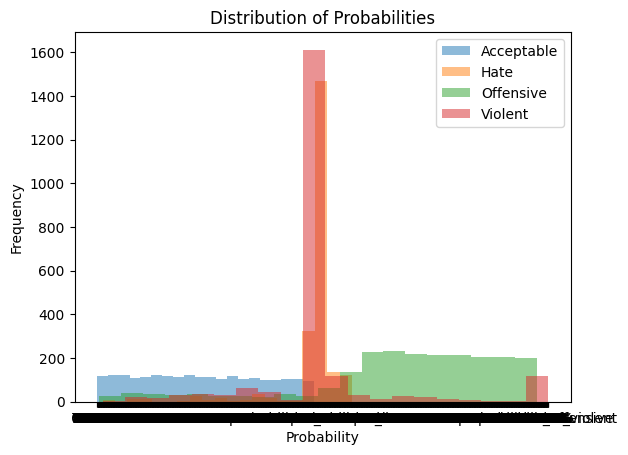

In [6]:
############## GRAPH 2 ####################
plt.hist(data['probabilities_acceptable'], bins=20, alpha=0.5, label='Acceptable')
plt.hist(data['probabilities_hate'], bins=20, alpha=0.5, label='Hate')
plt.hist(data['probabilities_offensive'], bins=20, alpha=0.5, label='Offensive')
plt.hist(data['probabilities_violent'], bins=20, alpha=0.5, label='Violent')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Probabilities')
plt.legend(loc='upper right')
plt.show()


In [ ]:
############## GRAPH 3 ####################
plt.plot(data['comment'], data['probabilities_acceptable'], label='Hate')
plt.plot(data['comment'], data['probabilities_hate'], label='Hate')
plt.plot(data['comment'], data['probabilities_offensive'], label='Offensive')
plt.plot(data['comment'], data['probabilities_violent'], label='Violent')
plt.xlabel('Comment')
plt.ylabel('Probability')
plt.title('Change in Probabilities over Comments')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
############## GRAPH 4 ####################

plt.scatter(data['probabilities_acceptable'],data['probabilities_hate'], data['probabilities_offensive'], c=data['probabilities_violent'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Hate Probability')
plt.ylabel('Offensive Probability')
plt.title('Scatter Plot of Hate vs. Offensive Probabilities')
plt.colorbar(label='Violent Probability')
plt.show()


In [ ]:
############## GRAPH 5 ####################

data[['probabilities_acceptable', 'probabilities_hate', 'probabilities_offensive', 'probabilities_violent']].plot(kind='bar', stacked=True)
plt.xlabel('Comment')
plt.ylabel('Probability')
plt.title('Content Type Probabilities in Each Comment')
plt.legend(title='Content Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
############## GENERATE IMAGES ####################

from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
dataset = pd.read_csv("reddit_posts_with_labels.csv", encoding='unicode_escape')

# Convert probability columns to numeric (float) type
probability_columns = ['probabilities_acceptable', 'probabilities_hate', 'probabilities_offensive', 'probabilities_violent']
for column in probability_columns:
    dataset[column] = dataset[column].str.rstrip('%').astype(float)

# Generate word clouds for each probability column
for column in probability_columns:
    filtered_comments = ' '.join(
        [text for text, prob_value in zip(dataset['comment'], dataset[column]) if prob_value >= 10]) 
    
    # Check if there are words to generate a word cloud
    if filtered_comments:
        # Generate and display the word cloud
        wordcloud = WordCloud(width=800, height=500,
                              random_state=21, max_font_size=110).generate(filtered_comments)
        
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f"Word Cloud for {column}")
        plt.show()
    else:
        print(f"No words found for {column}")
